In [85]:
%matplotlib notebook
import matplotlib.pyplot as plt

import pandas
from scipy import signal
from datetime import timedelta

In [293]:
from glob import glob
from sklearn import svm
from sklearn import tree
from sklearn import preprocessing

def train_dataset():
    directory = glob('../data/train/*.csv')
    train_files = list()
    for name in directory:
        df = pandas.read_csv(name)
        df['h_speed'] = (df['velN']**2 + df['velE']**2) ** 0.5
        df['v_speed'] = df['velD']
        df['h_speed'] = signal.savgol_filter(df['h_speed'], window_size, 0, mode='nearest')
        df['v_speed'] = signal.savgol_filter(df['v_speed'], window_size, 0, mode='nearest')

        train_files.append(df)
        
    return pandas.concat(train_files)
   
dataset = train_dataset()
dataset = dataset.loc[dataset['class'].isin([2, 3])]
dataset['is_flight'] = (dataset['class'] == 2).astype('float')

features = ['h_speed', 'v_speed']

dataset[features] = preprocessing.minmax_scale(dataset[features])

X_train = dataset[features]
y_train = dataset['is_flight']

svm_clf = svm.SVC(kernel='rbf', gamma=0.1, C=1)
svm_clf.fit(X_train, y_train)

linear_svc = svm.LinearSVC(C=0.1)
#linear_svc.fit(dataset['h_speed'], y_train)

svm_regr = svm.SVR(C=0.1, epsilon=0.2, gamma=0.001)
svm_regr.fit(X_train, y_train)

tree_clf = tree.DecisionTreeClassifier(max_depth=5)
tree_clf.fit(X_train, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

AVG Speed before jump:  40.3418875395


<IPython.core.display.Javascript object>


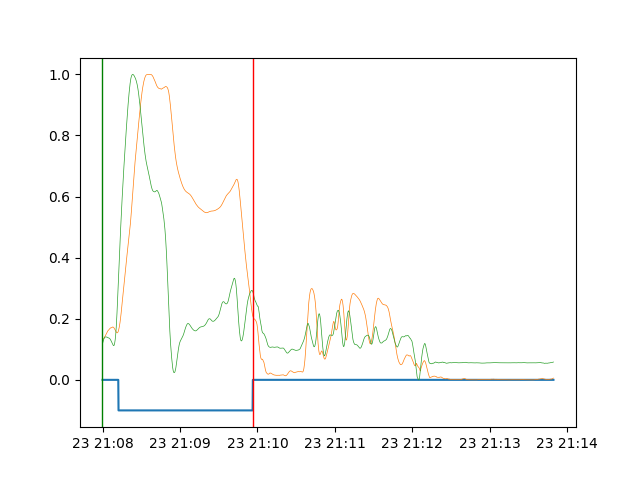

AVG Speed before jump:  59.2946930797


<IPython.core.display.Javascript object>


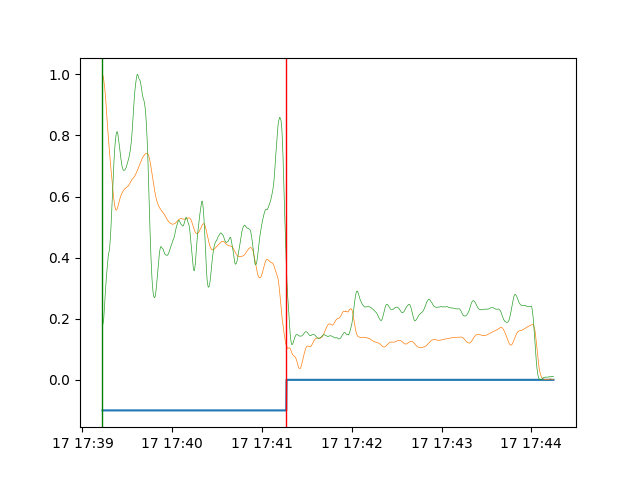

AVG Speed before jump:  0.142908113218


<IPython.core.display.Javascript object>


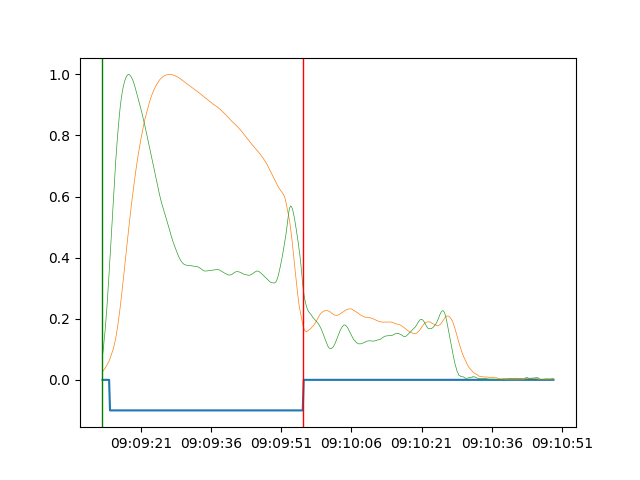

In [296]:
def predict_and_show(filename):
    df = pandas.read_csv('../data/test/' + filename)
    df['time'] = pandas.to_datetime(df['time'])
    df['prev_time'] = df.shift()['time']
    df['time_diff'] = df['time'] - df['prev_time']

    most_used_freq = df['time_diff'].value_counts().index.values[0]
    freq = 1000 / most_used_freq.astype('timedelta64[ms]').astype('float')
    window_size = freq * 3

    df.set_index('time', inplace=True)

    df['h_speed'] = (df['velN']**2 + df['velE']**2) ** 0.5
    df['v_speed'] = df['velD']
    df['h_speed'] = signal.savgol_filter(df['h_speed'], window_size, 0, mode='nearest')
    df['v_speed'] = signal.savgol_filter(df['v_speed'], window_size, 0, mode='nearest')

    V_SPEED_THRESHOLD = 7 # m/s
    df['flight_started'] = df['v_speed'].rolling(window='3s').mean().apply(lambda x: x > V_SPEED_THRESHOLD) 

    flight_start = df['flight_started'].ne(False).idxmax() - timedelta(seconds=2.55)


    print('AVG Speed before jump: ', df[:flight_start]['h_speed'].mean())
    
    df = df[flight_start:]
    df[features] = preprocessing.minmax_scale(df[features])
    
    X_test = df[features]
    
    df['predicted_svm'] = svm_clf.predict(X_test)

    plt.figure()
    plt.plot(df['predicted_svm'] * -0.1)
    plt.plot(X_test['h_speed'], linewidth=0.5)
    plt.plot(X_test['v_speed'], linewidth=0.5)
    plt.axvline(x=flight_start, color='green', linewidth=1)
    
    flight_end = df['predicted_svm'].eq(1).cumsum().idxmax()
    plt.axvline(x=flight_end, color='red', linewidth=1)


predict_and_show('#7990 15-56-18.CSV')
predict_and_show('Skydive Med WS 2 labeled.csv')
predict_and_show('Base Big WS labeled.csv')


plt.show()

<IPython.core.display.Javascript object>


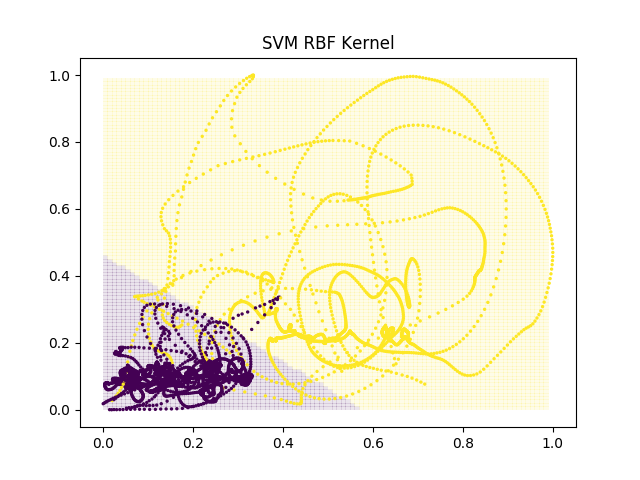

In [294]:
import numpy as np

plt.figure()
plt.scatter(X_train['h_speed'], X_train['v_speed'], c=dataset['is_flight'], zorder=10, s=2)

x_min, x_max = X_train['h_speed'].min(), X_train['h_speed'].max()
y_min, y_max = X_train['v_speed'].min(), X_train['v_speed'].max()

h = 0.01
XX, YY = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


Z = svm_clf.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
ax = plt.gca()
ax.pcolormesh(XX, YY, Z, alpha = 0.1)

plt.title('SVM RBF Kernel')

plt.show()